This notebook produces two models using the aggregated TLC and COVID-19 data-sets.
- Model 1: Predicing daily trip count using COVID-19 data
- Model 2: Predicting 2021-2022 tipping percentages using 2019-2022 data

In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')

pd.options.mode.chained_assignment = None

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 1 Modelling")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

22/08/21 22:28:50 WARN Utils: Your hostname, kelman_HP_ENVY resolves to a loopback address: 127.0.1.1; using 172.19.142.239 instead (on interface eth0)
22/08/21 22:28:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/08/21 22:28:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# import aggregate dataframes produced from analysis & visualisation notebook
yellow_19_20_sdf_agg = spark.read.parquet('../data/curated/yellow_19-20_agg/', header=True)
yellow_21_22_sdf_agg = spark.read.parquet('../data/curated/yellow_21-22_agg/', header=True)
fhvhv_19_20_sdf_agg = spark.read.parquet('../data/curated/fhvhv_19-20_agg/', header=True)
fhvhv_21_22_sdf_agg = spark.read.parquet('../data/curated/fhvhv_21-22_agg/', header=True)

yellow_21_22_sdf_agg_covid = spark.read.parquet('../data/curated/yellow_21-22_agg_covid/', header=True)
fhvhv_21_22_sdf_agg_covid = spark.read.parquet('../data/curated/fhvhv_21-22_agg_covid/', header=True)


In [3]:
# store Pandas version of all dataframes
yellow_21_22_df_agg_covid = yellow_21_22_sdf_agg_covid.toPandas()
fhvhv_21_22_df_agg_covid = fhvhv_21_22_sdf_agg_covid.toPandas()
yellow_19_20_df_agg = yellow_19_20_sdf_agg.toPandas()
yellow_21_22_df_agg = yellow_21_22_sdf_agg.toPandas()
fhvhv_19_20_df_agg = fhvhv_19_20_sdf_agg.toPandas()
fhvhv_21_22_df_agg = fhvhv_21_22_sdf_agg.toPandas()

In [4]:
def plot(model, file_name, name):
    '''Accepts an Ordinary Least Squares model object and creates diagnostic plots.'''

    fig, axes = plt.subplots(nrows=2, ncols=2)

    # residual vs fitted plot
    sns.scatterplot(model.fittedvalues, model.resid, ax=axes[0, 0])
    axes[0, 0].axhline(y=0, color='red', linestyle='dashed')
    axes[0, 0].set_title('Residuals vs Fitted')

    # qq plot
    sm.qqplot(model.resid, ax=axes[0, 1], line='r')
    axes[0, 1].set_title('Normal Q-Q')

    # scale-location plot
    sns.scatterplot(model.fittedvalues, model.resid_pearson, ax=axes[1, 0])
    axes[1, 0].set_title('Scale-Location')

    # standardised residuals vs leverage
    sns.scatterplot(model.get_influence().hat_matrix_diag, model.resid_pearson, ax=axes[1, 1])
    axes[1, 1].axhline(y=0, color='red', linestyle='dashed')
    axes[1, 1].set_title('Standardised Residuals vs Leverage')

    fig.tight_layout()
    fig.suptitle(f'Diagnostic Plots of {name}', horizontalalignment='center', weight='bold')
    fig.subplots_adjust(top=0.85)

    plt.savefig(f'../plots/{file_name}_diagnostic_plot.png')

    plt.show()

<h2><u>Model 1</u></h2>

In [5]:
def model1_train_predict(df_agg_covid):
    '''Accepts a Pandas dataframe of aggregated TLC data by date joined with COVID-19 data, splits the the data into 
        training and testing, fits a Linear Regression model to predict trip_count and predicts the test data using the 
        fitted model before producing evaluation metrics. A baseline model is also fitted.'''

    columns = ['trip_count', 'CASE_COUNT', 'HOSPITALIZED_COUNT']
    model_df = df_agg_covid.loc[:, columns]

    train_data, test_data = train_test_split(model_df, test_size=0.2, random_state=42)

    # fit linear regression models on train_data
    baseline = smf.ols(formula='trip_count ~ 1', data=train_data).fit()
    model = smf.ols("trip_count ~ CASE_COUNT + HOSPITALIZED_COUNT", data=train_data).fit()

    # baseline train data
    baseline_pred_train = baseline.predict(train_data)
    print('Baseline RMSE on train data: ', mean_squared_error(train_data['trip_count'], baseline_pred_train, squared=False)) 
    print('Baseline R2 on train data: ', r2_score(train_data['trip_count'], baseline_pred_train))

    # baseline test data
    baseline_pred_test = baseline.predict(test_data)
    print('Baseline RMSE on test data: ', mean_squared_error(test_data['trip_count'], baseline_pred_test, squared=False)) 
    print('Baseline R2 on test data: ', r2_score(test_data['trip_count'], baseline_pred_test))

    print('')

    # model train data
    model_pred = model.predict(train_data)
    print('Model RMSE on train data: ', mean_squared_error(train_data['trip_count'], model_pred, squared=False)) 
    print('Model R2 on train data: ', r2_score(train_data['trip_count'], model_pred))

    # model test data
    model_pred = model.predict(test_data)
    print('Model RMSE on test data: ', mean_squared_error(test_data['trip_count'], model_pred, squared=False)) 
    print('Model R2 on test data: ', r2_score(test_data['trip_count'], model_pred))

    print('')

    return model


In [6]:
def find_min_max(df, feature):
    '''Accepts a dataframe and feature, and prints the minimum and maximum value of that feature's column.'''

    print(f'Min {feature}: ', df[feature].min())
    print(f'Max {feature}: ', df[feature].max())

**Yellow Taxi**

Baseline RMSE on train data:  16378.276332250223
Baseline R2 on train data:  0.0
Baseline RMSE on test data:  21596.55206977868
Baseline R2 on test data:  -0.009864115702498122

Model RMSE on train data:  11546.75786531838
Model R2 on train data:  0.5029687110383708
Model RMSE on test data:  15657.199730910012
Model R2 on test data:  0.46921055001211587

Min trip_count:  26790
Max trip_count:  100420


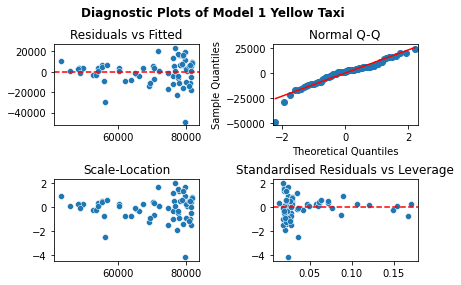

In [7]:
yellow_model1 = model1_train_predict(yellow_21_22_df_agg_covid)
find_min_max(yellow_21_22_df_agg_covid, 'trip_count')
plot(yellow_model1, 'yellow_model1', 'Model 1 Yellow Taxi')

**FHVHV**

Baseline RMSE on train data:  95954.6975138223
Baseline R2 on train data:  2.220446049250313e-16
Baseline RMSE on test data:  102583.44631075107
Baseline R2 on test data:  -0.017413412037613485

Model RMSE on train data:  78430.1178463183
Model R2 on train data:  0.3319126421686326
Model RMSE on test data:  75356.04356898804
Model R2 on test data:  0.4509915041757163

Min trip_count:  211026
Max trip_count:  726324


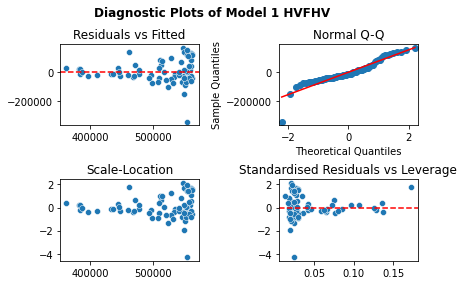

In [8]:
hvfhv_model1 = model1_train_predict(fhvhv_21_22_df_agg_covid)
find_min_max(fhvhv_21_22_df_agg_covid, 'trip_count')
plot(hvfhv_model1, 'hvfhv_model1', 'Model 1 HVFHV')

<h2><u>Model 2</u></h2>

In [9]:
def model2(df_19_20, df_21_22): 
    '''Accepts two Pandas dataframe of aggregated TLC data by date, fits a Linear Regression model on the 2019-2020 
        data to predict average tip percentage, and predicts the 2021-2022 data using the fitted model before producing 
        evaluation metrics. A baseline model is also fitted.'''
    ''''''

    train_data = df_19_20

    test_data = df_21_22

    baseline = smf.ols(formula='tip_percent_avg ~ 1', data=train_data).fit()
    columns = "+".join(train_data.columns.difference(['tip_percent_avg', 'date']))
    model = smf.ols("tip_percent_avg ~ " + columns, data=train_data).fit()

    # baseline train data
    baseline_pred_train = baseline.predict(train_data)
    print('Baseline RMSE on train data: ', mean_squared_error(train_data['tip_percent_avg'], baseline_pred_train, squared=False)) 
    print('Baseline R2 on train data: ', r2_score(train_data['tip_percent_avg'], baseline_pred_train))

    # baseline test data
    baseline_pred_test = baseline.predict(test_data)
    print('Baseline RMSE on test data: ', mean_squared_error(test_data['tip_percent_avg'], baseline_pred_test, squared=False)) 
    print('Baseline R2 on test data: ', r2_score(test_data['tip_percent_avg'], baseline_pred_test))
    
    print('')

    # model train data
    model_pred = model.predict(train_data)
    print('Model RMSE on train data: ', mean_squared_error(train_data['tip_percent_avg'], model_pred, squared=False)) 
    print('Model R2 on train data: ', r2_score(train_data['tip_percent_avg'], model_pred))

    # model test data
    model_pred = model.predict(test_data)
    print('Model RMSE on test data: ', mean_squared_error(test_data['tip_percent_avg'], model_pred, squared=False)) 
    print('Model R2 on test data: ', r2_score(test_data['tip_percent_avg'], model_pred))

    print('')

    return model

**Yellow Taxi**

Baseline RMSE on train data:  0.10000017518776073
Baseline R2 on train data:  0.0
Baseline RMSE on test data:  0.3433810728124108
Baseline R2 on test data:  -4.700367561597555

Model RMSE on train data:  0.08068844801641147
Model R2 on train data:  0.34893971682814695
Model RMSE on test data:  0.21486332760885432
Model R2 on test data:  -1.2319000840979668

Min tip_percent_avg:  15.242085473477747
Max tip_percent_avg:  16.117934504252013


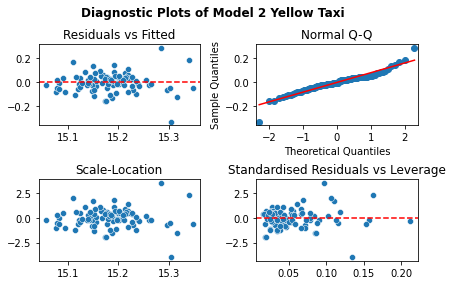

In [10]:
yellow_model2 = model2(yellow_19_20_df_agg, yellow_21_22_df_agg)
find_min_max(yellow_21_22_df_agg, 'tip_percent_avg')
plot(yellow_model2, 'yellow_model2', 'Model 2 Yellow Taxi')

**FHVHV**

Baseline RMSE on train data:  0.10534840344161359
Baseline R2 on train data:  0.0
Baseline RMSE on test data:  0.746321559804374
Baseline R2 on test data:  -20.53815634381976

Model RMSE on train data:  0.08956166981279678
Model R2 on train data:  0.2772494219541307
Model RMSE on test data:  0.8843262606684675
Model R2 on test data:  -29.239986532864872

Min tip_percent_avg:  2.712114582094739
Max tip_percent_avg:  3.3719618084272724


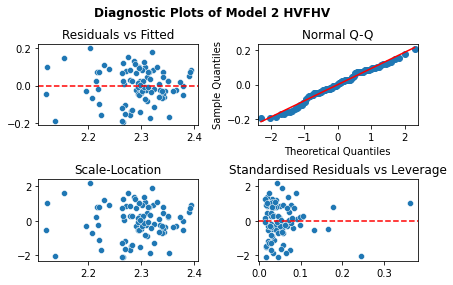

In [11]:
fhvhv_model2 = model2(fhvhv_19_20_df_agg, fhvhv_21_22_df_agg)
find_min_max(fhvhv_21_22_df_agg, 'tip_percent_avg')
plot(fhvhv_model2, 'hvfhv_model2', 'Model 2 HVFHV')